# Activation functions & Gradient Descent variations

For this assignment you'll be working with a slightly modified version of the neural network you wrote in the previous assignment. We'll start by outlining all of these modifications, after which you can get started on the assignment.

## Separating out the activation function

The first modification is that we've split the `LogisticLayer` class into two separate classes; `LinearLayer` and `SigmoidActivation`. The resulting computation graph will thus consist of two separate modules, one for the linear weights and one for the Sigmoid activation function:

<img src="src/cg08_3.svg" width="30%">

The `LinearLayer` holds all the weights of a layer and computes the $Z$ value for that layer. The `SigmoidActivation` then simply applies the Sigmoid function to $Z$ and computes the resulting $A_{next}$. Calling the `forward()` function on the `LinearLayer` and then on the `SigmoidActivation` is *identical* to calling `forward()` on the old `LogisticLayer`.

The same holds for the `backward()` functions of the two layers, which, when called first on `SigmoidActivation` and then on `LinearLayer`, also combine to a result that is identical to the `backward()` function of the old `LogisticLayer`. The only real change is that the `forward()` and `backward()` functions have just been split into two separate steps.

Make sure to read the code below and verify for yourself you understand how this relates to the `LogisticLayer` from the previous assignment. Note that `SigmoidActivation` doesn't have any weights itself, so the `step()` function for that class doesn't need to update any weights either.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from sklearn.model_selection import train_test_split
np.seterr(all='raise')

class LinearLayer():
    def __init__(self, s_in, s_out):
        # Randomly initialize the weights
        self.W = np.random.normal(scale=np.sqrt(2 / s_in), size=(s_out, s_in))
        self.b = np.zeros(s_out)
    
        # Activation input / output
        self.A = None
        self.Z = None
    
        # init the gradients (later computed in backward)
        # the gradient of W
        self.DW = np.zeros(self.W.shape)
        
        # the gradient of b
        self.Db = np.zeros(self.b.shape)
        
        # the gradient of input A (for backpropagation)
        self.DA = None
    
    def forward(self, A):
        self.A = A
        self.Z = np.matmul(A, self.W.T) + self.b
        return self.Z
    
    def backward(self, DZ):
        self.DW = np.matmul(DZ.T, self.A)
        self.Db = DZ.sum(axis=0)
        
        self.DA = np.matmul(DZ, self.W)
        return self.DA  
        
    def step(self, alpha = 0.1):
        self.b -= alpha * self.Db
        self.W -= alpha * self.DW

class SigmoidActivation:
    def __init__(self):
        # Activation input / output
        self.A_next = None
        self.DZ = None

    def forward(self, Z):        
        self.A_next = 1 / (1 + np.exp(-Z) + 1e-10)
        return self.A_next
        
    def backward(self, DA_next):        
        Df = self.A_next * (1 - self.A_next)
        
        self.DZ = Df * DA_next
        return self.DZ
    
    def step(self, alpha=0.1):
        # The activation function has no parameters to update
        pass
        
        

## Adding some features to the Neural Net 

The base of the `NN` class has remained exactly the same as the previous assignment, so the following code

    my_network = NN([7, 5, 3])

will create a network with 7 inputs, 5 hidden nodes and 3 outputs. The hidden nodes and outputs both consist of a `LinearLayer` for the weights, followed by a `SigmoidActivation`. The `forward()`, `backward()`, `cost()` and `step()` functions also do exactly the same in this case.

Alternatively, you can now also add the layers directly to the network, so the following code would create an identical network:

    my_network = NN([LinearLayer(7, 5),
                     SigmoidActivation(),
                     LinearLayer(5, 3),
                     SigmoidActivation()])
                     
This will of course become useful when you start adding different types of activation functions to the network, as the other initialization assumes the network consists of only `SigmoidActivation`s.

The last modification is for the case when the network has a Softmax output instead of a Sigmoid output. Using a Softmax output is usually combined with also changing the cost function and therefore the starting gradient for backpropagation. There is an optional argument in the `__init__` to make this change in the cost function and starting gradient, which is set to `False` by default. For now, when this argument is set to `True`, the cost and starting gradient are set to `None`, but in **Assignment 2** you should come back to this cell and fix the implementation here.


In [2]:
class NN():
    def __init__(self, layers, softmax_output=False):
        # Store the output type of the network
        self.softmax_output = softmax_output
        
        # layers is a list of integers, describing the number of nodes
        # at each layer
        if type(layers[0]) == int:
            self.layers = []
            for s_in, s_out in zip(layers[:-1], layers[1:]):
                # Add a LinearLayer and SigmoidActivation for each layer
                self.layers.append(LinearLayer(s_in, s_out))
                self.layers.append(SigmoidActivation())
        
        # Otherwise layers is assumed to contain already created
        # layer instances, which can be stored directly
        else:
            self.layers = layers

    def forward(self, X):
        """ Compute prediction for X based on self.layers"""
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        self.Y_hat = A
        return self.Y_hat
   
    def backward(self, Y):
        self.Y = Y
        
        if self.softmax_output:
            # Note: Fix this in Assignment 2
            DA = self.Y
            
        else:
            DA = -Y * 1 / self.Y_hat  + (1 - Y) * 1 / (1 - self.Y_hat)
        
        for layer in self.layers[::-1]:
            DA = layer.backward(DA)
    
    def cost(self, Y=None):
        if Y is None:
            Y = self.Y
        
        if self.softmax_output:
            # Note: Fix this in Assignment 2
            j = (Y * np.log(self.Y_hat)).sum(axis = 1)

        else:
            j = Y * np.log(self.Y_hat) + (1 - Y) * np.log(1 - self.Y_hat)
        
        return -j.sum()/len(Y)
    
    def step(self, alpha=0.1):
        for layer in self.layers:
            layer.step(alpha = alpha)

## Optimizing with different versions of gradient descent

The code below is very close to `optimize()` functions you've used before, only now there is an additional argument `batchsize`, which is set to `None` by default. If `batchsize` is set to `None`, the function will perform regular gradient descent. When using a different batchsize, the function should perform either *stochastic* or *mini-batch* gradient descent. The code for this is not yet completed, and it will be **assignment 3** to do so. For now this function just works as the regular gradient descent.

In [3]:
def optimize(model, X, y, alpha=0.0001, iterations=10000, batchsize=None):
    costs = []
    for i in trange(iterations):

        if batchsize is not None:
            indices = np.random.permutation(len(y))
            steps = len(y) // batchsize
            for j in range(steps):
                batch_ind = indices[j*batchsize:(j+1)*batchsize]
                batch_X = X[batch_ind]
                batch_y = y[batch_ind]
                
                # Note: Complete this in Assignment 3
                model.forward(batch_X)
                model.backward(batch_y)
                model.step(alpha)
        
        else:
            model.forward(X)
            model.backward(y)
            model.step(alpha)
            
            if len(costs) >= 2 and (costs[-2] - costs[-1]) < 0:
                print(f'Diverging at iteration {len(costs)}')
                return costs
        
        # keep track of costs
        costs.append(model.cost())

        
    return costs


## Loading and preprocessing the digits data

Here we define some useful functions for evaluating and visualising the data. In addition, the digits data is loaded, preprocessed for use with a neural network, and split into train and test sets.

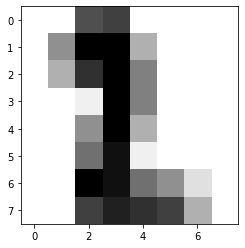

The label for this digit was: 2


In [4]:
from scipy.stats import zscore

def plot_costs(costs):
    plt.plot(range(len(costs)), costs)
    plt.xlabel("Iteration of Gradient Descent")
    plt.ylabel("Training Cost")
    plt.ylim(bottom=0)
    plt.show()

def evaluate(neural_net, X_train, Y_train, X_test, Y_test):
    for X_data, Y_data, label in zip([X_train, X_test], [Y_train, Y_test], ['Train', 'Test']):
        print('\nEvaluating', label)

        Y_hat = neural_net.forward(X_data)
        print('Cost:', neural_net.cost(Y_data))

        predictions = Y_hat.argmax(axis=1)
        targets = Y_data.argmax(axis=1)
        print('Accuracy', (predictions == targets).sum() / len(Y_data) * 100)

def display_digit(i, digits):
    digit_sample = np.ones((8,8))*16 - np.reshape(digits[i, :-1], (8, 8))
    plt.imshow(digit_sample, cmap='gray', vmax=16)
    plt.show()
    print("The label for this digit was:", digits[i, -1])

digits = np.loadtxt('data/digits123.csv', delimiter=',', dtype=int)

display_digit(200, digits)

# Normalize the values of the pixels to be between 0 and 1
X = digits[:, :-1] / 16
X_mean = np.mean(X, axis=0, keepdims=True)
X -= X_mean

# Generate one-hot encoding for Y
y = digits[:, -1]
Y = np.eye(y.max())[y - y.min()]

# Load the already backpropagated weights for the network
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7, test_size = 0.3,  random_state=11)


## Training the network

With all this code written, making and training the network becomes very straightforward. We can build and evaluate an effective classifier in just a few lines. Note that we're still dependent on random initialization of the network weights, so you might have to run the code a few times. However, most initializations should reach at least *99%* accuracy on the test set without problem.

100%|██████████| 10000/10000 [00:03<00:00, 2702.98it/s]


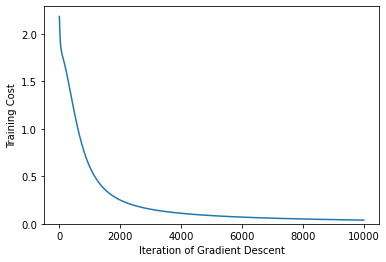


Evaluating Train
Cost: 0.038659379242080724
Accuracy 100.0

Evaluating Test
Cost: 0.07065621805564985
Accuracy 99.38650306748467


In [5]:
digitNN = NN([64, 5, 3])

costs = optimize(digitNN, X_train, Y_train)
plot_costs(costs)

evaluate(digitNN, X_train, Y_train, X_test, Y_test)

## Building a deeper network

Clearly a network with a single hidden layer with 5 nodes is very suitable to solve this problem. However, for more complex problems you'll need to use more hidden layers (i.e. make the network deeper). Below is the code to use **7 hidden layers**, each consisting of **5 nodes.** 

**Q1. What do you expect will happen when running this code? What will the training / testing accuracy look like? Motivate your answers.**

*The code above has 1 hidden layer, consisting of 5 nodes. The plot of that outcome shows that the algorithm converges at around 2000 iterations because the derivative of the training cost approaches zero quite rapidly. Adding more nodes enables the algorithm to solve more complex problems.

I would expect that, if you add nodes and layers for a simple network like this, the programme would take more time to run because of all the functions it needs to pass. And the plot may become less steep because of this. But the accuracy would not necessarily increase because it is already so high: a simple network with only one layer can already do this quite accurately.
*

100%|██████████| 10000/10000 [00:19<00:00, 522.28it/s]


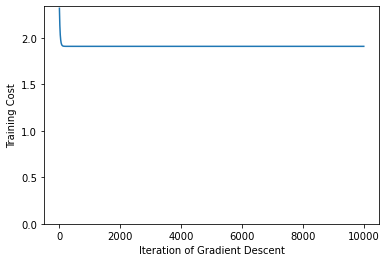


Evaluating Train
Cost: 1.9088279503611265
Accuracy 45.11873350923483

Evaluating Test
Cost: 1.9111464493817618
Accuracy 43.558282208588956


In [6]:
np.random.seed(0)

digitNN = NN([64, 5, 5, 5, 5, 5, 5, 5, 3])

costs = optimize(digitNN, X_train, Y_train)
plot_costs(costs)

evaluate(digitNN, X_train, Y_train, X_test, Y_test)

np.random.seed()

## Surprising results?

If you haven't done so yet, run the code above. What you should see is that the cost doesn't go down much *at all*, and *both* the training and testing accuracy remain very low. Remember that, as there are 3 digit classes to choose from, *33%* accuracy is only as good as a random guess.

What you might have expected, is that with this more complex network, with many more weights to learn, that the network would **overfit** the training data. However, if this would have happened, the training cost would actually have become very small and accuracy on the training set should also have been very high, while giving very poor performance on the test set, as these learned weights would not generalize well to new examples.

In these results, the training cost is hardly decreasing at all, so clearly something else must be going on. The results might look more like underfitting, but we know it can't be that, as a much simpler model was able to solve the problem. In fact, it has something to do with the derivative of the Sigmoid function. The plot below should help shed some light on the situation.


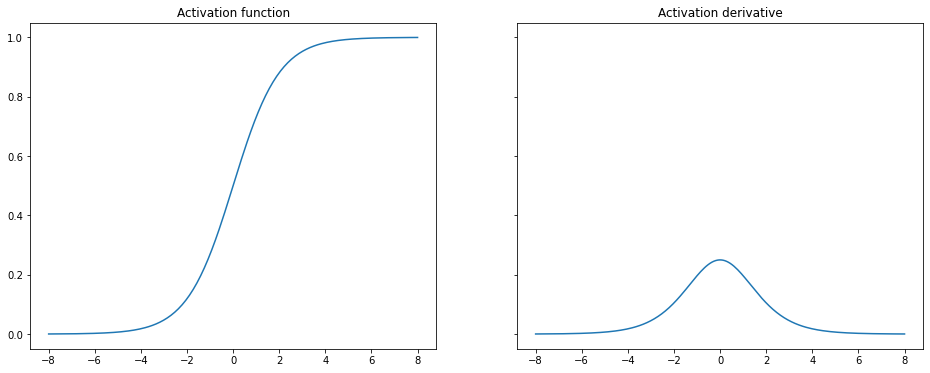

In [7]:
def plot_activation(activation):
    x = np.expand_dims(np.linspace(-8, 8, 200), axis=1)
    
    f_x = activation.forward(x)
    f_prime_x = activation.backward(np.ones(f_x.shape))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))
    
    ax1.set_title("Activation function")
    ax1.plot(x, f_x)
    
    ax2.set_title("Activation derivative")
    ax2.plot(x, f_prime_x)
    
    plt.show()


plot_activation(SigmoidActivation())

## Activation function derivatives

What you can see in the plot above, is that the derivative of the Sigmoid function is really small in many cases, with the original function being almost completely flat when the output is very close to either 0 or 1, resulting in a derivative close to 0. Even at its highest point the derivative is only *0.25*, which is still quite a bit smaller than 1.

Why is this a problem? Well, during backpropagation, we also backpropagate *through* the activation function. The original equation from backward assignment for this was

$$
\frac{\partial l}{\partial Z} = A_{\mathrm{next}}\odot(1 \ominus A_{\mathrm{next}}) \odot \frac{\partial l}{\partial A_{\mathrm{next}}}
$$

where the term

$$
A_{\mathrm{next}}\odot(1 \ominus A_{\mathrm{next}})
$$

is just the derivative of the Sigmoid function (the activation function used here), for every element in the input matrix $Z$.

This means at every step backwards we multiply with the derivative of the activation function. If there are many layers to backpropagate through and at every step we multiply with something (much) smaller than one, then the gradients at the first layer become so small that the update doesn't do much anymore. This is called **the vanishing gradient problem**, which results in deep networks that aren't capable of learning the correct weights anymore! 

## Assignment 1: ReLU Activation

This is where the ReLU activation function comes in. Its derivative is 1 for many input values, allowing for gradients to be passed backwards through much deeper networks. Take a look at the activation functions and derivative theory videos for the exact equations for ReLU and its derivative, and implement these in the `forward()` and `backward()` functions below. You may choose if you set the derivative of the 0 input to either 0 or 1, but you cannot leave it undefined for the implementation.

Remember that the `forward()` and `backward()` functions should work for whole matrices of activations, for many samples and nodes at once, so you should use *Numpy* functions to program them. Check your own solution by verifying the graphs produced for the ReLU activation below.


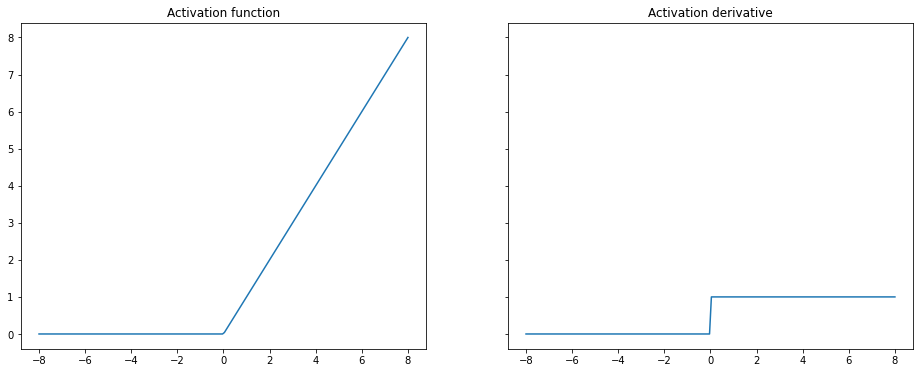

In [8]:
class ReLUActivation:
    def __init__(self):
        self.Z = None
        self.A_next = None
        self.DZ = None

    def forward(self, Z):
        self.Z = Z
        
        # regular RELU: a = max(0, z)
        self.A_next = np.maximum(0, self.Z)
        
        return self.A_next
        
    def backward(self, DA_next):
        
        # use broadcasting to create a boolean array
        Df = self.Z > 0

        self.DZ = Df * DA_next
        
        return self.DZ
    
    def step(self, alpha=0.1):
        pass

    
plot_activation(ReLUActivation())

## Problem solved?

Below is the code for the same 7 hidden layers, each with 5 nodes, but this time using ReLU activations for each of the hidden layers. Below that is a similar setup to before, with only 1 hidden layer. Run the cells and then answer the questions below.

**Q2. Explain why you should still use a Sigmoid activation at the final output layer, even when switching to ReLU for the hidden layers.**

As andrew Ng explained, activation functions like tanh and Relu ussually work better than the sigmoid functions. But he also explained that the sigmoid function is superior when it comes to the output layer because "when y is an output either zero and 1, then you'd want y-hat to be a number between 0 and 1. Then, you'd use the sigmoid function. So in this case also, we should still use the sigmoid functions.

**Q3. How do the results below differ from hidden layers with Sigmoid activations? Are there any surprising results that stand out to you?**

An important difference is that the training costs actually approach zero. That is a good thing. In addition, sometimes there seem to be saddles and plateaus when I run the programme as the training costs stay constant for a while and then move further down.

**Q5. Do these results imply the ReLU completely solved the issues with vanishing gradients? Motivate your answer.**

Sigmoid causes a vanishing gradient as the gradient approaches zero (becomes really small) as backpropagation progresses. Relu ensures that the derivative is constant (1) in most cases. This prevents the gradient from approaching zero while it is back-propagated. 

So it helps, but the gradient may be zero in some cases. That can be problematic if the gradient is zero for all the samples so that the weights will also become zero. This is the "dead-neuron" problem. In this way, solving the problem of vanishing gradients with ReLU could cause problems with the weights so that we can't really update in a meaningfull manner. 


100%|██████████| 10000/10000 [00:17<00:00, 585.55it/s]


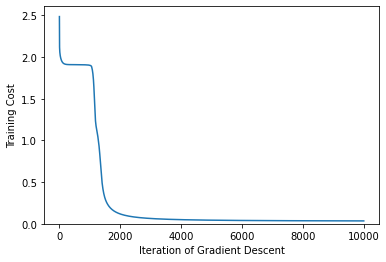


Evaluating Train
Cost: 0.034672821476639484
Accuracy 99.73614775725594

Evaluating Test
Cost: 0.32238540383996195
Accuracy 96.93251533742331


In [9]:
digitNN = NN([LinearLayer(64, 5), ReLUActivation(), 
              LinearLayer(5, 5), ReLUActivation(),
              LinearLayer(5, 5), ReLUActivation(),
              LinearLayer(5, 5), ReLUActivation(),
              LinearLayer(5, 5), ReLUActivation(),
              LinearLayer(5, 5), ReLUActivation(),
              LinearLayer(5, 5), ReLUActivation(),
              LinearLayer(5, 3), SigmoidActivation()])

costs = optimize(digitNN, X_train, Y_train)
plot_costs(costs)

evaluate(digitNN, X_train, Y_train, X_test, Y_test)


100%|██████████| 10000/10000 [00:06<00:00, 1449.00it/s]


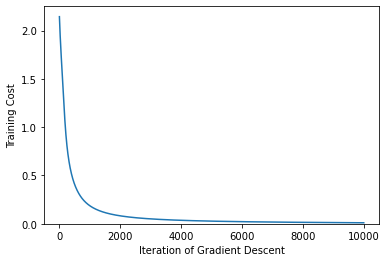


Evaluating Train
Cost: 0.010584420154424996
Accuracy 100.0

Evaluating Test
Cost: 0.02924586762476657
Accuracy 99.38650306748467


In [10]:
digitNN = NN([LinearLayer(64, 5), ReLUActivation(), 
              LinearLayer(5, 3), SigmoidActivation()])

costs = optimize(digitNN, X_train, Y_train)
plot_costs(costs)

evaluate(digitNN, X_train, Y_train, X_test, Y_test)

## Softmax activation

Up to now we've used a cost function of the form

$$
J = -\sum_{i=1}^m \sum_{k=1}^o y^i_k log(\hat{y}^i_k) +  (1 - y^i_k) log(1 - \hat{y}^i_k)
$$

where $m$ is the number of samples, $o$ is the number of output nodes, and $\hat{y}^i_k$ is the network prediction for the $i^{th}$ sample at the $k^{th}$ node. The target variable here is a one-hot encoding $y$ and minimizing this cost function ensures the Sigmoid output node that should be _"on"_ for each sample gets as close to *1* as possible and all others get as close to *0* as possible. Once the cost function has been minimized, we can get a prediction for a sample by simply selecting the output node with the highest activation.

All of this works well, as we've seen, but for larger problems, especially with more classes to choose from, a different activation usually works better. However, changing this output activation also requires changing the cost function and even what starting gradient for backpropagation is used. For this assignment we'll step through the required changes


### Assignment 2a: Softmax activation function

The Softmax function takes in a whole *vector* of node activations at the output layer and produces a new vector of outputs. For the $k^{th}$ output node, the equation is as follows

$$
\sigma(z)_k = \frac{e^{z_k}}{\sum_j {e^{z_j}}}
$$

This activation is called the Softmax function, as the largest value will get close to 1 and the other close to 0. This is similar to an argmax, but instead of the highest value becoming exactly 1, we get a *soft* distribution over the outputs. The exponent $e^{z_k}$ will amplify any difference between the values and make the larger inputs relatively larger still, which is what gives the soft maximization effect.

The softmax outputs for one vector of inputs will always sum together to be exactly 1, as each output is normalized by dividing by $\sum_j e^{z_j}$. This also means we can interpret the output of the softmax as the *probability* of a sample being that specific class, giving us values that are much easier to directly interpret. 

For this assignment you should implement the `forward()` function to work for a whole matrix of inputs, where each row is the input vector for one specific sample. As this is not so easy, a lot of the work has already been done in the `forward()` function. Try to figure out what the final step for the forward function should be and complete the code there. 

### Assignment 2b: Negative log likelihood cost function

When switching to a Softmax activation at the last layer, it is important to also change the cost function you are using. The standard cost function that is combined with the softmax activation is the negative log likelihood:

$$
J = -\sum_{i=1}^m \sum_{k=1}^o y^i_k log(\hat{y}^i_k)
$$

As you can see, this is actually a simplification from the binary cross-entropy cost function from before. The cost function now only _"cares"_ about keeping the correct output as high as possible, which is more closely aligned with the maximization goal. So, it doesn't matter if the other outputs are close to 0 or not, as long as the correct output is as high as possible.

Note that because all the outputs are normalized by $\sum_j e^{z_j}$, making one output larger will *necessarily* make the other outputs smaller. This is not the case when using a Sigmoid activation, so this cost function really *cannot* be used for Sigmoid outputs. You should either use Sigmoid outputs and a binary cross-entropy cost function, or use Softmax outputs and a negative log likelihood cost function.

To indicate this difference, the `NN` class has already been provided with an optional argument `softmax_output`, which as a default is set to `False`. The `cost()` function in that class (at the top of this file) has been written to give a different cost when `softmax_output` is set to `True`. When this value is set to true, currently the following code gets executed

    j = None
    
which will lead to an error. Replace this line in the `cost()` function of the `NN` class with the correct expression.

### Assignment 2c: NN backward function

For this last part we'll have to update the derivatives of the functions we've changed, so backpropagation will still work. 


Before, in the `backward()` function of `NN` we would first compute:

$$
\frac{\partial l}{\partial \hat{y}}
$$

which is the partial derivative of the loss with respect to the network output. The network output corresponds to the activations at the *last layer*, so for the last layer this is equivalent to determining:

$$
\frac{\partial l}{\partial a_{next}}
$$

<br>

Then we would pass this term backwards through the layers, and at Sigmoid backward we would compute

$$
\frac{\partial l}{\partial z} = a_{next}(1 - a_{next})\frac{\partial l}{\partial a_{next}}
$$

combining the output derivative with the activation function derivative to obtain the next term for backpropagation.

However, as we saw in the previous notebook too, these equations could be combined and tend to simplify things a lot. This is even more so the case for the Softmax, as working out the derivative of that function gets very messy. Specifically, when combined with the derivative of the negative log likelihood, things simplify *a whole lot*. In fact, the whole simplified equation then just becomes:

$$
\frac{\partial l}{\partial z} = a_{next} - y
$$

All the terms in these equations will cancel, in a very similar way to how they did for Logistic Regression. This is another reason why using the negative log likelihood together with Softmax activation is so important; it greatly simplifies the math.

In order to make use of this simplification we'll have to change two things. First, in the `NN` class `backward()` function, we no longer want to compute the starting gradient

    DA = -Y * 1 / self.Y_hat  + (1 - Y) * 1 / (1 - self.Y_hat)
    
Instead, when using a Softmax activation, we just want to pass `Y` directly to the output layer, as we'll do the combined derivative there in one step. Currently, when `softmax_output` is set to `True`, then `DA` becomes `None`. You should fix the starting value of `DA` in the `backward()` function of the `NN` class so it is set to the correct value when `softmax_output` is `True`, so that `Y` is passed directly to the `backward()` function of the output layer.

### Assignment 2d: Softmax backward function

Lastly, we'll need to write the `backward()` function for the `SoftmaxActivation`, which should now be simplified a lot, as the function takes `Y` directly as an argument. Complete the simplified equation for `DZ` in the `backward()` function of the `SoftmaxActivation`. Remember that equation can now be simplified to:

$$
\frac{\partial l}{\partial z} = a_{next} - y
$$

Run the tests below and make sure everything looks correct before moving on to the next step.


100%|██████████| 10000/10000 [00:06<00:00, 1586.55it/s]


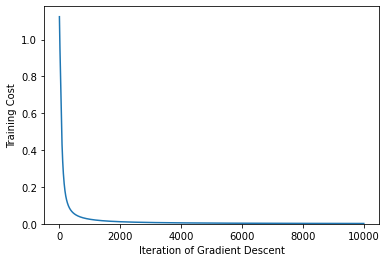


Evaluating Train
Cost: 0.0016955400116802192
Accuracy 100.0

Evaluating Test
Cost: 0.007486619274147621
Accuracy 100.0


In [11]:
class SoftmaxActivation:
    def __init__(self):
        self.A_next = None
        self.DZ = None

    def forward(self, Z):
        E = np.exp(Z)
        S = np.sum(E, axis=1, keepdims=True)

        self.A_next = E / S
        
        return self.A_next
        
    def backward(self, Y):

        self.DZ = self.A_next - Y
        
        return self.DZ

    
    def step(self, alpha = 0.1):
        pass


digitNN = NN([LinearLayer(64, 5), ReLUActivation(),  
              LinearLayer(5, 3), SoftmaxActivation()],
             softmax_output=True)

costs = optimize(digitNN, X_train, Y_train)
plot_costs(costs)

evaluate(digitNN, X_train, Y_train, X_test, Y_test)

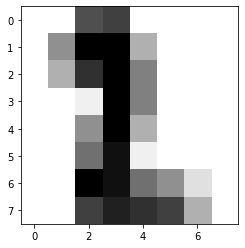

The label for this digit was: 2


Network predicted this is a 1 with probability 0.02297
Network predicted this is a 2 with probability 0.97702
Network predicted this is a 3 with probability 0.00000


In [12]:
# Change this to try other examples! (any value from 0 to 541 should work)
digit_index = 200

display_digit(digit_index, digits)

digit_out = digitNN.forward(digits[digit_index, :-1] / 16 - X_mean)

print('\n')
for i in range(3):
    print(f'Network predicted this is a {i+1} with probability {digit_out[0,i]:.5f}')


## Gradient Descent variations

As you've seen in the theory videos, there are some common variations of the Gradient Descent algorithm, which are especially useful for very large training sets, specifically mini-batch gradient descent and stochastic gradient descent. Both of these reduce the number of training samples considered before updating the weights. Mini-batch will process a small subset of the training data before updating the weights and stochastic will even just update after a *single* training sample! Note that if you set the size of the mini-batch to 1, you simply end up with stochastic gradient descent.

There are a couple of advantages to these variants over full-batch gradient descent. Firstly, having to process all the examples before making a single update, will make the algorithm very slow, so making smaller updates in between can speed things up. It might even be the case that the training data is so large it doesn't completely fit in the memory, making it necessary to split the training data into smaller batches. These smaller batches are created randomly, which means they can actually help to escape local minima! Even if the gradient for the whole data set is very small at some point, we can still get a lucky subset of the data that might point us in the right direction.

These effects won't be visible on such a small and simple set, but we'll still try and run some quick experiments here. Note that, due to small data set size, we might actually be *losing* speed, as we can't really take full advantage of the matrix operations in these small batches.

### Assignment 3: Mini-batch Gradient Descent

In the `optimize()` function at the top of the file, the case when `batchsize` is set to a value other than `None` is currently incomplete. The code to divide the training data into random batches has already been provided, add the last steps for mini-batch gradient descent to the function. Note that you should *not* check for divergence here, mini-batch gradient descent will inherently be noisy, as it is not following the true gradient of the cost function at every step. When you've completed the function, run the 3 experiments below and answer the following question.

**Q5. What changes do you observe when running the algorithm with different batchsizes? Try to explain each of these changes based on the theory of the algorithm.**

The first plot is not really noisy; the curve is really smooth.

The second the number of iterations is 1000 and the effect is that the plot is more noisy but it seems that the algortihm does converge.

the third number of iterations is 20 and the effect is that the plot is much more noisy. but even then, it seems that the algorithm does converge.

100%|██████████| 10000/10000 [00:06<00:00, 1588.05it/s]


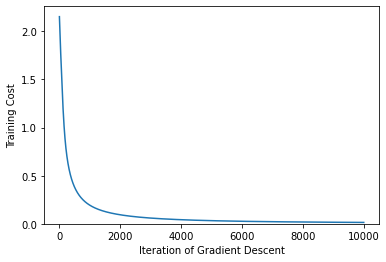


Evaluating Train
Cost: 0.014208864411448465
Accuracy 100.0

Evaluating Test
Cost: 0.0401101622265756
Accuracy 100.0


In [13]:
digitNN = NN([LinearLayer(64, 5), ReLUActivation(), 
              LinearLayer(5, 3), SigmoidActivation()])

costs = optimize(digitNN, X_train, Y_train, batchsize=None)
plot_costs(costs)

evaluate(digitNN, X_train, Y_train, X_test, Y_test)

100%|██████████| 10000/10000 [00:09<00:00, 1086.17it/s]


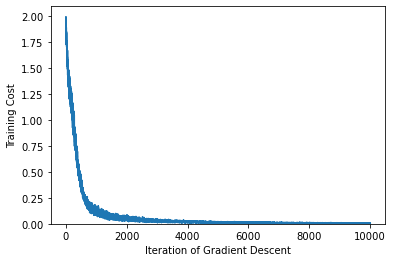


Evaluating Train
Cost: 0.005610405371303151
Accuracy 100.0

Evaluating Test
Cost: 0.025235824754733474
Accuracy 99.38650306748467


In [14]:
digitNN = NN([LinearLayer(64, 5), ReLUActivation(), 
              LinearLayer(5, 3), SigmoidActivation()])

costs = optimize(digitNN, X_train, Y_train, batchsize=100)
plot_costs(costs)

evaluate(digitNN, X_train, Y_train, X_test, Y_test)

100%|██████████| 10000/10000 [00:41<00:00, 243.79it/s]


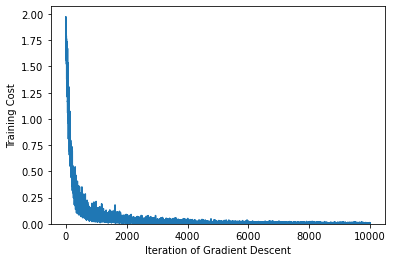


Evaluating Train
Cost: 0.004250774201122665
Accuracy 100.0

Evaluating Test
Cost: 0.02124380031409592
Accuracy 100.0


In [15]:
digitNN = NN([LinearLayer(64, 5), ReLUActivation(), 
              LinearLayer(5, 3), SigmoidActivation()])

costs = optimize(digitNN, X_train, Y_train, batchsize=20)
plot_costs(costs)

evaluate(digitNN, X_train, Y_train, X_test, Y_test)